In [ ]:
import warnings
warnings.filterwarnings("ignore")

# TRANSFORMERS & PIPELINES

### WHOAA! I like TRANSFORMERS too but NO! I ain't talking about Autobots or Decepticons!
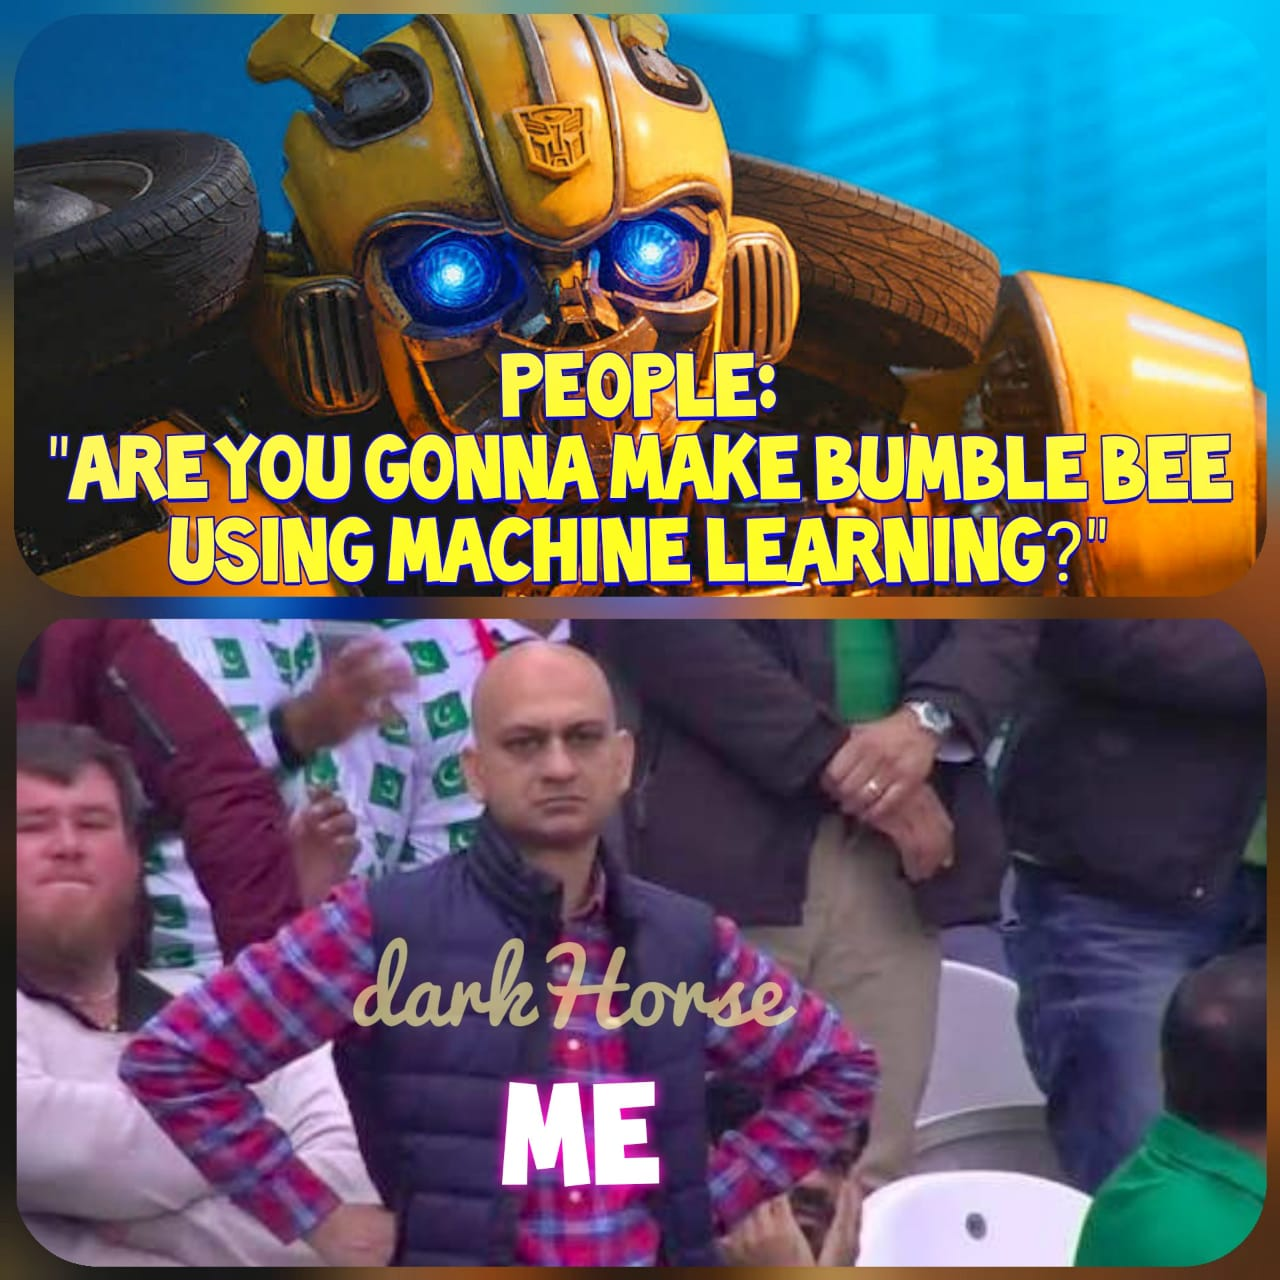

Transformers are being widely used in the field of Natural Language Processing (NLP). We will be seeing a small demo of the use of Transformers and Pipeline in this kernel.

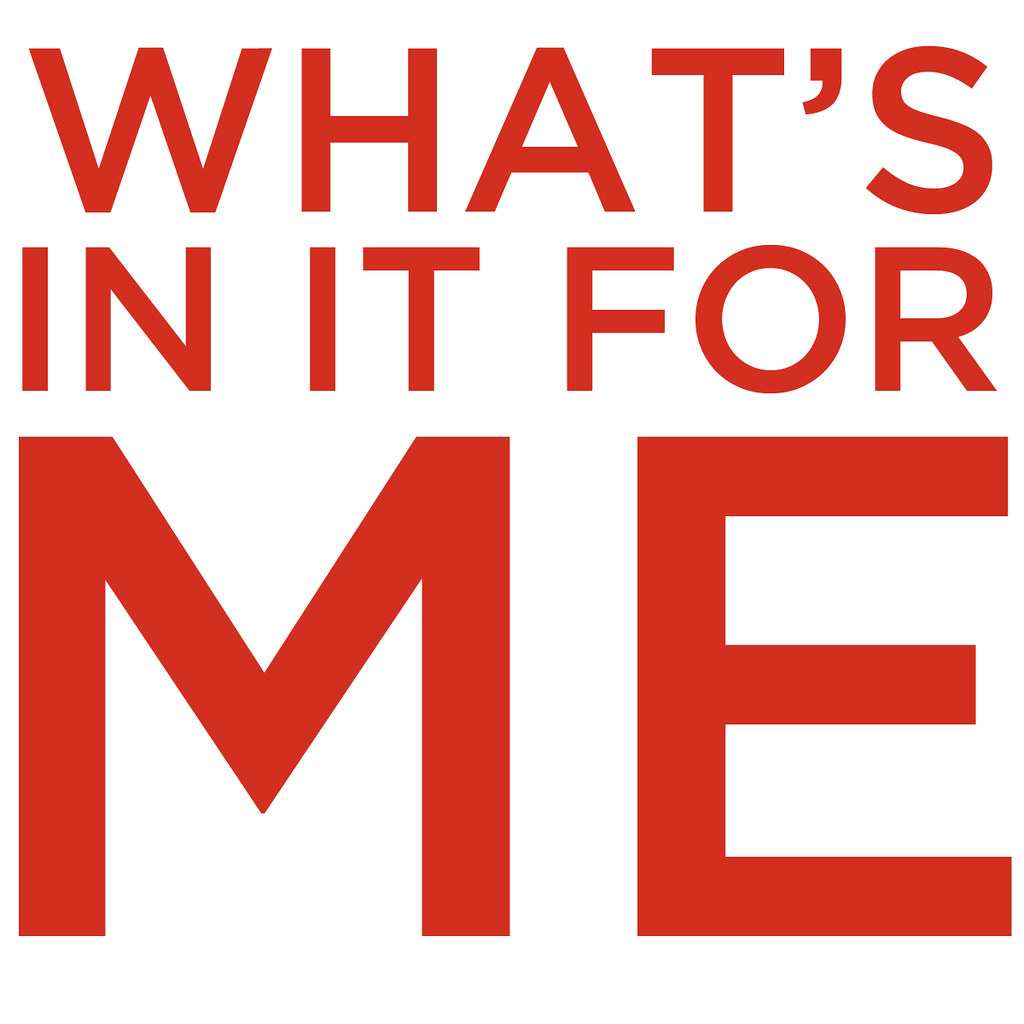

### Transformers and Pipeline can simplify the process of dealing with data, preprocessing it and automating the entire process.
### A typical approach of dealing with data includes cleaning, scaling, removing and adding features, normalizing and clipping values on the **train data** and then applying the same transfomation on the **test data** before passing it to the trained model.
### This entire task of performing the same transformations again and again could make the process look messy and vulnerable to commiting errors.
## This is where Transformers and Pipeline kicks in!
All thanks to the good old Skicit-learn, implementing a transformer could be as simple as :

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
column_transformer = ColumnTransformer("One_Hot_Encoder",OneHotEncoder(),[0,1,2],remainder="passthrough")

A short breakdown of the code above:

* **"One_Hot_Encoder"** : Name of the Transformer. Depends on the user.

* **OneHotEncoder()** : The Transformer Class object to be used.

* **[0,1,2]** : The array indices for transformation. Feature/column names can also be used.

* **remainder="passthrough"** : To ensure that the transformation is done only to the specified columns and the remaining                           columns are left as it is.

### Let's explore the **adult-cencus-income** dataset to determine if a person earns more than 50K.

# IMPORTING LIBRARIES & DATASET

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
train_data = pd.read_csv("../input/adult-census-income/adult.csv")
train = train_data.copy()

In [ ]:
print("Train Data Shape : {}".format(train.shape))

In [ ]:
train.head(2)

In [ ]:
# remove dot(.) from column names and insert '_'
for col in train.columns:
    new_name = col.replace(".","_")
    train.rename(columns={col:new_name},inplace=True)

# DATA STATISTICS

In [ ]:
#train data statistics
train_stats = pd.DataFrame()
train_stats["Columns"] = train.columns
train_stats["Missing_Values"] = train.isna().sum().values
train_stats["Unique_values"] = [train[x].nunique() for x in train.columns]
train_stats["Column_Type"] = [train[x].dtypes for x in train.columns]
skewness = []
for col in train.columns:
    try:
        skew = train[col].skew()
        skewness.append(skew)
    except:
        skewness.append("NA")
train_stats["Skewness"] = skewness
train_stats

The above table is just a compilation of a few details about the columns in the dataset. It's a personal taste as I like to view those details in the form of a dataframe.

# PLOTS

In [ ]:
#visualizations
train.hist(figsize=(12,9))
plt.tight_layout()
plt.show()

In [ ]:
## Categorical plots for inference. Uncomment and run.
# categorical = ["workclass","education","marital_status","occupation","relationship","race","sex"]
# cnt = 0
# for cat in categorical:
#     plt.figure(figsize=(12,7))
#     sns.countplot(cat,hue="income",data=train)
#     plt.show()

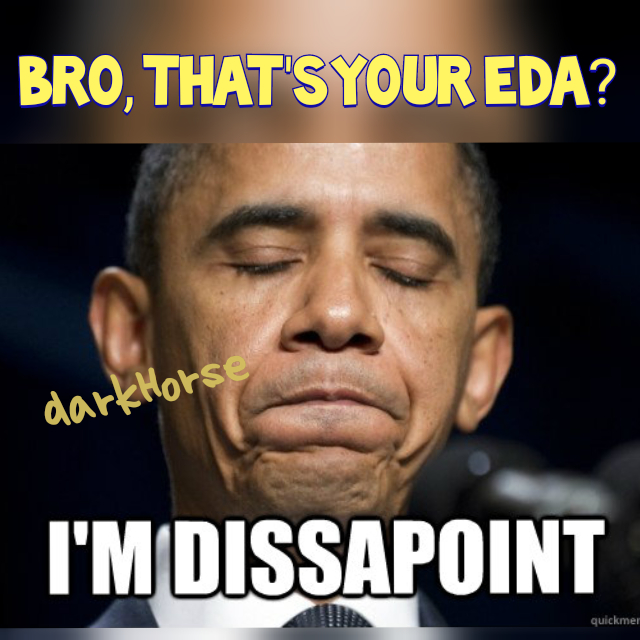

Obviously the **EDA** could be much better! Real-life data holds a plenty of hidden truths in them. Believe me! I had to force myself not to bring all those up as it would divert us from the **main topic** in hand which is **Transformers and Pipeline**!

# DATA CLEANING/ENCODING/MODIFICATION

In [ ]:
#mapping target variable to make it binary
income_map = {"<=50K":0,">50K":1}
train.income = train.income.map(income_map)

In [ ]:
df = train[["age","workclass","fnlwgt","education","education_num","occupation","sex","capital_gain","capital_loss","hours_per_week","income"]].copy()

In [ ]:
most_frequent = df.capital_gain.value_counts(ascending=False).index[0]
freq = df.capital_gain.value_counts(ascending=False)[0]
print("Percentage of frequency of {} value in /capital_gain/ column = {}%".format(
    most_frequent,round((freq/df.capital_gain.value_counts().sum())*100,2)))

most_frequent = df.capital_loss.value_counts(ascending=False).index[0]
freq = df.capital_loss.value_counts(ascending=False)[0]
print("Percentage of frequency of {} value in /capital_loss/ column = {}%".format(
    most_frequent,round((freq/df.capital_loss.value_counts().sum())*100,2)))

### We observed that there is majority issue here. As over 90% of the data in both columns are the same, they won't be adding much information to the model. Hence, we remove them.

In [ ]:
df = df.drop(["capital_gain","capital_loss"], axis=1)

In [ ]:
X = df.drop("income",axis=1)
y = df.income

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=3)

In [ ]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

## Do we always have to depend on Scikit-learn for the transformers we plan to use? What if we want a certain transformation in our data which is not present in there? Pack up?!

## Nope! You can customize your own transformer too.
### However, while constructing the customized transformer, one must keep in mind the format followed by the classes in Scikit-learn so that the transformer can perform as desired.

#### Filling up diesel in a petrol-engine car would definitely result in the malfunctioning of the vehicle right?!
#### [ DISCLAIMER : Please don't try the above stunt! I am not responsible for any kind of loss, accidents or explosions! ]

# CUSTOM TRANSFORMER

Here we will be looking at the construction of a basic transformer performing log2, log10, square root or cube root operations on the data according to the parameter passed.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class transformation(BaseEstimator, TransformerMixin):
    def __init__(self,method="log2"):
        self.method = method
    def fit(self,X,y=None):
        #In this case the fit function is empty.
        return self
    def transform(self,X):
        X_ = X.copy()
        for col in X_.columns:
            if self.method == "log2":
                X_[col] = np.log2(X_[col])
            elif self.method == "log10":
                X_[col] = np.log10(X_[col])
            elif self.method == "sqrt":
                X_[col] = np.sqrt(X_[col])
            elif self.method == "cbrt":
                X_[col] = np.cbrt(X_[col])
        return X_

* Did you observe that the '**fit**' function has a '**return self**' statement?
It is the basic layout in any class function of Scikit-learn. It helps in **chaining**. We do observe codes where data is first **fitted** using '**.fit()**' and then **transformed** using '**.transform()**'. This chaining is possible due to the return self in the fit function.

* BaseEstimator and TransformerMixin helps in making sure that the transformer performs well in he pipeline. Moreover, BaseEstimator aids the use of GridSearchCV while tunning the hyperparameters.

You can check out their source codes here : [BaseEstimator](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py#L151) and [TransformerMixin](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/base.py#L660)

In [ ]:
# # code for testing the skewness when respective transformations are done on each column
# for col in ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]:
#     print("\nOriginal Skewness for {} is {}".format(col,df[col].skew()))
#     for method in ["log2","log10","sqrt","cbrt"]:
#         trans = transformation(method)
#         trans.fit(df[col])
#         print("\nSkewness after {} transformation = {}".format(method,trans.transform(df[col]).skew()))
#     print("\n")

### It's common to see a dataset with variety of data. Some columns could be nominal, others could be ordinal and a few of them maybe in need of some normalization. If you want to know more about **nominal-ordinal data** or **implementation** of different kinds of **encoding** used [Click Here](https://www.kaggle.com/hkalita/feature-encoding/notebook). 
#### Hence, we need something that applies the respective transformations only to particular columns.
### Here comes the concept of Column Transformer.

In [ ]:
col_trans = make_column_transformer(
            (transformation("sqrt"),["age","fnlwgt"]),
            (OneHotEncoder(sparse=False),["workclass","education","occupation","sex"]),
            (StandardScaler(),["age","fnlwgt","education_num","hours_per_week"]),
            remainder = "passthrough"
            )

The **remainder = "passthrough"** ensures that only the mentioned columns undergo through the particular transformer and the remaining columns are left as it is.

In [ ]:
#cross folds
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=3)
#model
logreg = LogisticRegression(solver="lbfgs")

In [ ]:
#defining the steps for the pipeline
steps = [
    ("Col_trans",col_trans),
    ("Model",logreg)    
]
pipe = Pipeline(steps)

In [ ]:
score_with_pipeline = cross_val_score(pipe,X,y,cv=cv,scoring="accuracy")

In [ ]:
print("Mean Accuracy: {:.2f}%".format(score_with_pipeline.mean()*100))
print("Standard Deviation among Accuracy scores: {:.6f}".format(score_with_pipeline.std()))

In [ ]:
#fitting the pipeline
pipe.fit(X_train,y_train)

In [ ]:
#predicting on the test data
y_pred = pipe.predict(X_test[["age","workclass","fnlwgt","education","education_num","occupation","sex",
                              "hours_per_week"]])
print("Accuracy on the Test Data: {:.2f}%".format(accuracy_score(y_test,y_pred)*100))

### Did you observe that we didn't actually do any pre-processing on the test data?!
### The pipeline we made was directly used on the test data without any pre-processing from our side. It was performed by the pipeline itself before predicting the target on the test data. This is a big relief and saves a lot of time as well as makes the implementation look neat.

## If you enjoyed the Kernel do Upvote for support!
## As this was a basic implementation, in the next kernels I will try to perform Hyperparameter tuning using GridSearchCV on a pipeline.

## HAPPY LEARNING

### If you have any queries regarding the kernel or views on Data Science do reach out to me on [LinkedIn](https://www.linkedin.com/in/hrishikesh-kalita-1aa746173/).

-Everthing Teaches Us Something